In [2]:
import sys 
sys.path.append("C:/Users/isxzl/OneDrive/Code/AutoGeo")
from tqdm import tqdm  
from sample.unit_test import generate_example, generate_large_dataset	


# ERA5 Tool Box

Get Shortname of all


unify the time, date, edition version, null

dirty GRIB(ERA5) ---> clean GRIB(ERA5)

return cleaned grib file path.

In [ ]:
# Get edition number in file

In [ ]:
import sys 
sys.path.append("C:/Users/isxzl/OneDrive/Code/AutoGeo")
from sample.grib import get_shortname_edition
import eccodes
from tqdm import tqdm
import os

def get_shortname_edition(path: str) -> dict:
    """
    Collects all unique shortName keys for each edition in a GRIB file.

    Args:
        path (str): The path to the GRIB file.

    Returns:
        dict: A dictionary where each key is an edition and the value is a list of unique shortNames for that edition.
    """
    # Dictionary to collect all unique shortName keys by their edition
    edition_shortnames = {}

    # Open the GRIB file in binary read mode
    with open(path, 'rb') as f:
        # Determine the total size for progress estimation
        total_size = os.path.getsize(path)

        # Initialize the progress bar
        with tqdm(total=total_size, unit='B', unit_scale=True, desc="Analyzing GRIB file") as pbar:
            while True:
                # Decode the next GRIB message
                gid = eccodes.codes_grib_new_from_file(f)
                if gid is None:
                    break  # No more messages
                
                # Get the shortName and edition for the current message
                short_name = eccodes.codes_get(gid, 'shortName')
                edition = eccodes.codes_get(gid, 'edition')
                
                # Initialize the list for this edition if not already present
                if edition not in edition_shortnames:
                    edition_shortnames[edition] = set()

                # Add the shortName to the set for this edition
                edition_shortnames[edition].add(short_name)
                
                # Release the current GRIB message to free memory
                eccodes.codes_release(gid)
                
                # Update the progress bar based on the file's current position
                current_position = f.tell()
                pbar.update(current_position - pbar.n)
    
    # Convert sets to lists for the output
    for edition in edition_shortnames:
        edition_shortnames[edition] = list(edition_shortnames[edition])

    return edition_shortnames
 


## Estimate, delete the Null Varible 

In [271]:
import eccodes
import numpy as np
import xarray as xr

import eccodes
import eccodes
from tqdm import tqdm
import os 
import eccodes
import os
from tqdm import tqdm

def check_null_and_step_edition(file_path: str) -> dict:
    """
    Counts the missing values for each shortName in a GRIB file, checks if they have a coordinate step,
    and collects all unique shortName keys for each edition.

    Args:
        file_path (str): The path to the GRIB file.

    Returns:
        dict: Three dictionaries inside a dict:
              - 'summary': With shortName as keys and a sub-dictionary as values, where the sub-dictionary contains
                'missing' and 'total' counts.
              - 'summary2': With keys 'has_step' and 'hasnt_step' listing unique shortNames according to whether
                they have a coordinate step or not.
              - 'summary3': Similar to edition_shortnames, where each key is an edition and the value is a list of
                unique shortNames for that edition.
    """
    summary = {}
    has_step = set()
    hasnt_step = set()
    edition_shortnames = {}  # New dictionary for collecting unique shortNames by edition

    # Determine the total size of the input file for progress estimation
    total_size = os.path.getsize(file_path)

    with open(file_path, 'rb') as f, tqdm(total=total_size, unit='B', unit_scale=True, desc="Analyzing GRIB file") as pbar:
        while True:
            gid = eccodes.codes_grib_new_from_file(f)
            if gid is None:
                break  # End of file
            
            short_name = eccodes.codes_get(gid, 'shortName')
            edition = eccodes.codes_get(gid, 'edition')  # Retrieve the edition for the current message
            values = eccodes.codes_get_values(gid)
            missing_value = eccodes.codes_get(gid, 'missingValue')
            
            missing_count = (values == missing_value).sum()
            total_values = len(values)
            
            if short_name not in summary:
                summary[short_name] = {'missing': 0, 'total': 0}
            summary[short_name]['missing'] += missing_count
            summary[short_name]['total'] += total_values

            # Initialize the list for this edition if not already present
            if edition not in edition_shortnames:
                edition_shortnames[edition] = set()
            edition_shortnames[edition].add(short_name)  # Add the shortName to the set for this edition

            # Check for coordinate step
            try:
                eccodes.codes_get(gid, 'step')
                has_step.add(short_name)
            except Exception:
                if short_name not in has_step:
                    hasnt_step.add(short_name)
            
            eccodes.codes_release(gid)
            
            # Update the progress bar based on the current file read position
            current_position = f.tell()
            pbar.update(current_position - pbar.n)

    # Convert sets to lists for the output
    for edition in edition_shortnames:
        edition_shortnames[edition] = list(edition_shortnames[edition])
    summary2 = {"has_step": list(has_step), "hasnt_step": list(hasnt_step)}
    summary3 = edition_shortnames  # Convert the edition_shortnames dict to the required format

    return {'null': summary, 'step': summary2, 'edition': summary3}



    
import matplotlib.pyplot as plt

def plot_grib_null(count_stat: dict) -> None:
    """
    Plots the distribution of null counts in given categories.

    Args:
        count_stat (dict): Dictionary of counts of missing values per variable.
    """
    categories = {'<10': [],'10-25': [], '25-50': [], '50-100': [], '100-1000': [], '>1000': []}

    for var, stats in count_stat.items():
        missing = stats['missing']
        
        if 0 <  missing < 10:
            categories['<10'].append(var)     
        elif 10 <= missing <= 25:    
            categories['10-25'].append(var)
        elif 25 < missing <= 50:
            categories['25-50'].append(var)
        elif 50 < missing <= 100:
            categories['50-100'].append(var)
        elif 100 < missing <= 1000:
            categories['100-1000'].append(var)
        elif missing > 1000:
            categories['>1000'].append(var)
 

    # For simplicity, here we print the categories, but you can adjust to plot as needed
    for cat, vars in categories.items():
        print(f'{cat}: {", ".join(vars)}')
    return categories
    
from typing import List, Tuple, Set
import eccodes
from tqdm import tqdm
import os

def filter_grib_file(input_grib_file_path: str, variables_to_delete: List[str],name: str="_filtered" ) -> Tuple[str, Set[str]]:
    """
    Filters out specified variables from a GRIB file and saves the result to a new file. Also returns a set of remaining variables.

    Args:
        input_grib_file_path (str): The path to the input GRIB file.
        variables_to_delete (List[str]): A list of variable names (shortName) to be excluded from the output file.
        name: name: str="_filtered.grib"  as default
    Returns:
        Tuple[str, Set[str]]: The path to the filtered output GRIB file and a set of variables that were not excluded.
    """
    # Define the output file path based on the input file path
    
    output_grib_file_path = input_grib_file_path.replace('.grib', name +'.grib')

    # Initialize a set to keep track of remaining variables
    remaining_variables = set()

    # Open the input GRIB file
    with open(input_grib_file_path, 'rb') as input_file, open(output_grib_file_path, 'wb') as output_file:
        # Determine the total size of the input file for progress estimation
        total_size = os.path.getsize(input_grib_file_path)

        # Initialize the progress bar
        with tqdm(total=total_size, unit='B', unit_scale=True, desc="Processing GRIB file") as pbar:
            while True:
                # Use eccodes to read each message from the input GRIB file
                gid = eccodes.codes_grib_new_from_file(input_file)
                if gid is None:
                    break  # Break the loop if we have reached the end of the file
                
                # Retrieve shortName of the current parameter
                short_name = eccodes.codes_get(gid, 'shortName')
                
                # If the variable is not in the delete list, write it to the output file and add to remaining variables
                if short_name not in variables_to_delete:
                    coded_message = eccodes.codes_get_message(gid)
                    output_file.write(coded_message)
                    remaining_variables.add(short_name)
                    
                # Release the current message to avoid memory leaks
                eccodes.codes_release(gid)
                
                # Update the progress bar
                current_position = input_file.tell()
                pbar.update(current_position - pbar.n)  # Update progress based on the amount of data processed

    print(f"Filtered GRIB file has been saved to: {output_grib_file_path}")
    return output_grib_file_path, remaining_variables

import eccodes

def get_unique_variables_from_grib(file_path):
    unique_variables = set()

    # Open the GRIB file
    with open(file_path, 'rb') as f:
        while True:
            gid = eccodes.codes_grib_new_from_file(f)
            if gid is None:
                break  # End of the file

            # Get the short name of the current variable
            short_name = eccodes.codes_get(gid, 'shortName')
            unique_variables.add(short_name)

            # Release the current GRIB message to free memory
            eccodes.codes_release(gid)

    return unique_variables

# Example usage
#file_path = filterd_grib_path_step
#unique_vars = get_unique_variables_from_grib(file_path)
#print("Unique variables in the GRIB file:", unique_vars)


In [265]:
# Example usage
grib_file_path = r'C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\2021_Oct.grib'

count_stat = check_null_and_step_edition(grib_file_path)

# Example usage
interval_stat = plot_grib_null(count_stat["null"])

# remove the variable which has more than 100 null value and edition.
variables_to_delete=set(interval_stat[">1000"]+count_stat["edition"][2])
filterd_grib_path, shortname_list=filter_grib_file(grib_file_path,variables_to_delete)



Analyzing GRIB file: 100%|███████████████████████████████████████████████████████▉| 88.6M/88.6M [01:08<00:00, 1.30MB/s]


<10: vima, viman
10-25: 
25-50: 
50-100: 
100-1000: 
>1000: bfi, cbh, cin, ci, sst, ust, vst


Processing GRIB file: 100%|██████████████████████████████████████████████████████▉| 88.6M/88.6M [00:55<00:00, 1.59MB/s]


Filtered GRIB file has been saved to: C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\2021_Oct_filtered.grib


In [ ]:
ds=xr.open_dataset(filterd_grib_path, engine='cfgrib') # Build index
#print(shortname_list)
#print(interval_stat) 
ds

In [267]:
def detect_step_ds(ds):
    variable_names_no_step=set()
    variable_names_step=set()
    ds_step_flag=0
    ds_no_step_flag=0
    for name in tqdm(shortname_list) :
        ds =xr.open_dataset(filterd_grib_path, engine='cfgrib',
                             backend_kwargs={'filter_by_keys':{'shortName': name}})
        if len(ds.sizes)==3:
            variable_names_no_step.add(name)     
            if ds_no_step_flag:
                ds_no_step= xr.merge([ds_no_step, ds],compat='override') #
            else:
                ds_no_step=ds
                ds_no_step_flag=1
                
        elif len(ds.sizes)==4:
            variable_names_step.add(name) 
            if ds_step_flag:
                ds_step= xr.merge([ds_step, ds],compat='override')
            else:
                ds_step=ds
                ds_step_flag=1
        else:
            pass
            #print(name)
            #print(len(ds.sizes))
    return ds_step, ds_no_step
ds_step, ds_no_step=detect_step_ds(ds)     

100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [04:01<00:00,  1.17s/it]


## Next Merge

In [268]:
import eccodes
from tqdm import tqdm
import xarray as xr
import cfgrib
import pandas as pd

def merge_time_and_step(ds):
    """
    将 'step' 维度合并到 'time' 维度中。

    Parameters:
    ds (xarray.Dataset): 原始数据集。

    Returns:
    xarray.Dataset: 转换后的数据集。
    """
    # 创建一个新的空的列表来存储新的时间和相应的数据

    if 'step' in ds:
        new_times = []
        data_arrays = []
    
        # 遍历每个 time 和 step 的组合
        for t in tqdm(ds['time'].values):
            for s in ds['step'].values:
                new_time = pd.to_datetime(t) + pd.to_timedelta(s)
                new_times.append(new_time)
    
                # 选择对应的数据并更新时间
                da = ds.sel(time=t, step=s)
                da = da.expand_dims(time=[new_time])
                data_arrays.append(da)
    
        # 合并所有的数据数组
        combined = xr.concat(data_arrays, dim='time')
    
        # 删除 'step' 维度
        del combined['step']
    # 如果 'edition' 维度存在，则删除
    if 'edition' in combined.dims or 'edition' in combined:
        combined = combined.drop_vars('edition', errors='ignore')
        
    return combined
 

In [269]:
ds=xr.open_dataset(filterd_grib_path, engine='cfgrib') # Build index
#print(shortname_list)
#print(interval_stat) 
ds
ds_step_merged=merge_time_and_step(ds_step)
dataset = xr.merge([ds_step_merged, ds_no_step],compat='override')
# Save it to netcdf
dataset.to_netcdf(filterd_grib_path.replace('.grib', '.nc'))
#dataset = xr.open_dataset(path.replace('.grib', '.nc'))

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [01:24<00:00,  2.05s/it]


In [270]:
dataset

<xarray.Dataset>
Dimensions:              (time: 492, latitude: 19, longitude: 19)
Coordinates:
  * time                 (time) datetime64[ns] 2021-09-30T19:00:00 ... 2021-1...
  * latitude             (latitude) float64 31.5 31.25 31.0 ... 27.5 27.25 27.0
  * longitude            (longitude) float64 118.0 118.2 118.5 ... 122.2 122.5
    number               int32 0
    surface              float64 0.0
    valid_time           (time) datetime64[ns] 2021-09-30T19:00:00 ... 2021-1...
    step                 timedelta64[ns] ...
    depthBelowLandLayer  float64 ...
    entireAtmosphere     float64 ...
Data variables: (12/207)
    megwss               (time, latitude, longitude) float32 nan nan ... nan nan
    tplt                 (time, latitude, longitude) float32 nan nan ... nan nan
    i10fg                (time, latitude, longitude) float32 nan nan ... nan nan
    ssr                  (time, latitude, longitude) float32 nan nan ... nan nan
    strd                 (time, latitude, longitude) float32 nan nan ... nan nan
    lgws                 (time, latitude, longitude) float32 nan nan ... nan nan
    ...                   ...
    vimae                (time, latitude, longitude) float32 nan nan ... nan nan
    tsn                  (time, latitude, longitude) float32 nan nan ... nan nan
    viked                (time, latitude, longitude) float32 nan nan ... nan nan
    viec                 (time, latitude, longitude) float32 nan nan ... nan nan
    viken                (time, latitude, longitude) float32 nan nan ... nan nan
    src                  (time, latitude, longitude) float32 nan nan ... nan nan
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-02-02T22:01 GRIB to CDM+CF via cfgrib-0.9.1...

# Load_ERA5()

given:
- ear5_dir

wanted:
- Xarray contains all data.

## Single

In [1]:
import joblib
import os
import sys
sys.path.append("C:/Users/isxzl/OneDrive/Code/AutoGeo")
from sample.grib import load_era, find_files_with_extension

directory = r'C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\air'
ds1=load_era(find_files_with_extension(directory,"grib")[0])
ds2=load_era(find_files_with_extension(directory,"grib")[1])
ds3=load_era(find_files_with_extension(directory,"grib")[2])

========filter file detected========
========merged nc file detected========
========filter file detected========
========merged nc file detected========
========filter file detected========
========merged nc file detected========


In [ ]:
ds1

## Batch

In [1]:

import joblib
import os
import sys
sys.path.append("C:/Users/isxzl/OneDrive/Code/AutoGeo")
from sample.grib import load_era5_batch
#ds.sel(time="2022-01-01 00:00:00")["vimad"].plot()
directory = r'C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\land'
m_ds=load_era5_batch(directory)
#m_ds.sel(time="2022-02-01T00:00:00.000000000")["zust"].plot()

[autoGEO][Info] Process 1th file in 14
========filter file detected========
========merged nc file detected========
[autoGEO][Info] Process 2th file in 14
========filter file detected========
========merged nc file detected========
[autoGEO][Info] Process 3th file in 14
========filter file detected========
========merged nc file detected========
[autoGEO][Info] Process 4th file in 14
========filter file detected========
========merged nc file detected========
[autoGEO][Info] Process 5th file in 14
========filter file detected========
========merged nc file detected========
[autoGEO][Info] Process 6th file in 14
========filter file detected========
========merged nc file detected========
[autoGEO][Info] Process 7th file in 14
========filter file detected========
========merged nc file detected========
[autoGEO][Info] Process 8th file in 14


Analyzing Edition: 100%|█████████████████████████████████████████████████████████▉| 20.2M/20.2M [00:03<00:00, 5.40MB/s]
Filtering: 100%|█████████████████████████████████████████████████████████████████▉| 20.2M/20.2M [00:03<00:00, 6.25MB/s]


Filtered GRIB file has been saved to: C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\land\_filtered\22_Jan_17-20.grib


Merging Step: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.67it/s]


[autoGEO][Info] Process 9th file in 14


Analyzing Edition: 100%|█████████████████████████████████████████████████████████▉| 20.2M/20.2M [00:03<00:00, 5.40MB/s]
Filtering: 100%|█████████████████████████████████████████████████████████████████▉| 20.2M/20.2M [00:03<00:00, 6.31MB/s]


Filtered GRIB file has been saved to: C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\land\_filtered\22_Jan_21-24.grib


Merging Step: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


[autoGEO][Info] Process 10th file in 14


Analyzing Edition: 100%|█████████████████████████████████████████████████████████▉| 35.5M/35.5M [00:06<00:00, 5.54MB/s]
Filtering: 100%|█████████████████████████████████████████████████████████████████▉| 35.5M/35.5M [00:05<00:00, 6.08MB/s]


Filtered GRIB file has been saved to: C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\land\_filtered\22_Jan_25-31.grib


Merging Step: 100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.21it/s]


[autoGEO][Info] Process 11th file in 14


Analyzing Edition: 100%|█████████████████████████████████████████████████████████▉| 20.3M/20.3M [00:03<00:00, 5.44MB/s]
Filtering: 100%|█████████████████████████████████████████████████████████████████▉| 20.3M/20.3M [00:03<00:00, 5.44MB/s]


Filtered GRIB file has been saved to: C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\land\_filtered\22_Mar_01-04.grib


Merging Step: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


[autoGEO][Info] Process 12th file in 14


Analyzing Edition: 100%|█████████████████████████████████████████████████████████▉| 30.4M/30.4M [00:06<00:00, 5.06MB/s]
Filtering: 100%|█████████████████████████████████████████████████████████████████▉| 30.4M/30.4M [00:04<00:00, 6.14MB/s]


Filtered GRIB file has been saved to: C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\land\_filtered\22_Mar_05-10.grib


Merging Step: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.23it/s]


[autoGEO][Info] Process 13th file in 14


Analyzing Edition: 100%|█████████████████████████████████████████████████████████▉| 42.8M/42.8M [00:08<00:00, 5.31MB/s]
Filtering: 100%|█████████████████████████████████████████████████████████████████▉| 42.8M/42.8M [00:06<00:00, 6.22MB/s]


Filtered GRIB file has been saved to: C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\land\_filtered\22_Mar_11-20.grib


Merging Step: 100%|████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[autoGEO][Info] Process 14th file in 14


Analyzing Edition: 100%|█████████████████████████████████████████████████████████▉| 34.2M/34.2M [00:05<00:00, 5.78MB/s]
Filtering: 100%|█████████████████████████████████████████████████████████████████▉| 34.2M/34.2M [00:05<00:00, 6.60MB/s]


Filtered GRIB file has been saved to: C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\land\_filtered\22_Mar_21-31.grib


Merging Step: 100%|██████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.52it/s]


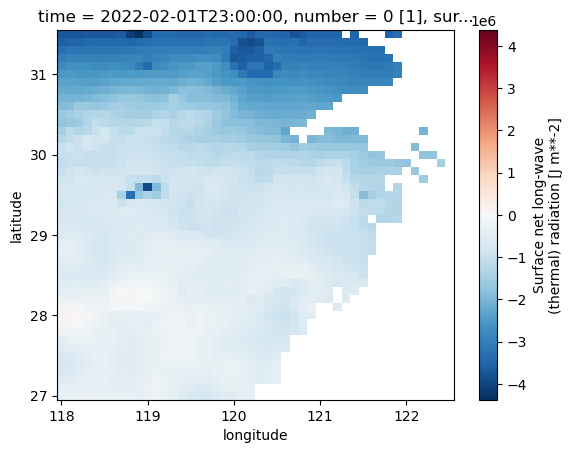

In [12]:
m_ds.sel(time='2022-02-01T23:00:00.000000000')["str"].plot()